# Install Required Libraries

In [1]:
!pip install mediapipe
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 27.0 MB/s eta 0:00:00


#Import Libraries


In [14]:
import kagglehub
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import random
from concurrent.futures import ThreadPoolExecutor
from google.colab.patches import cv2_imshow  # Import the Colab-specific imshow function
from skimage.metrics import structural_similarity as ssim
import pandas as pd


# Download Dataset

In [3]:
path = kagglehub.dataset_download("ashwingupta3012/human-faces")
print("Path to dataset files:", path)
path = path + "/Humans"


100%|██████████| 1.82G/1.82G [00:16<00:00, 120MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1


#Data Exploration (Previewing the Dataset)

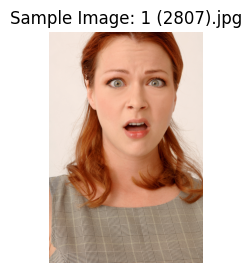

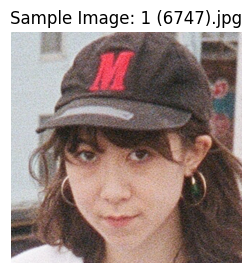

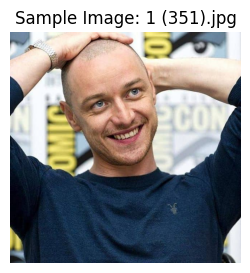

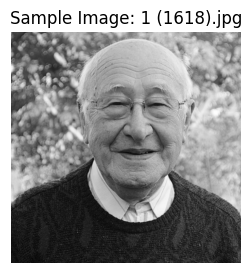

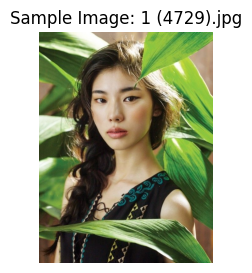

Image Shapes: [(2312, 1536, 3), (600, 600, 3), (640, 640, 3), (1206, 1200, 3), (733, 550, 3)]


In [4]:
# Preview some sample images in the dataset to understand the structure
image_files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_images = image_files[:5]

# Display some sample images
for img_file in sample_images:
    img_path = os.path.join(path, img_file)
    img = Image.open(img_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Sample Image: {img_file}")
    plt.show()

# Optional: Check the dimensions of the images to ensure consistency
image_shapes = [np.array(Image.open(os.path.join(path, img))).shape for img in sample_images]
print("Image Shapes:", image_shapes)


#Define the FaceReconstructor Class

In [15]:
class FaceReconstructor:
    def __init__(self, image_size=128, num_basis=1000):
        self.image_size = image_size
        self.num_basis = num_basis

    def preprocess_image(self, image_path):
        """Simplified and faster preprocessing"""
        img = Image.open(image_path).convert('L')
        img = img.resize((self.image_size, self.image_size))
        img_array = np.array(img, dtype=np.float32)
        img_array = img_array / 255.0  # Normalize to [0, 1]
        return img_array.flatten()

    def process_batch(self, file_batch):
        """Process a batch of images in parallel"""
        vectors = []
        for file_name in file_batch:
            try:
                vector = self.preprocess_image(file_name)
                if np.var(vector) > 0.01:  # Exclude low-variance images
                    vectors.append(vector)
            except Exception:
                continue
        return vectors

    def build_basis(self, dataset_path, exclude_path=None, batch_size=50):
        """Faster basis vector building with batch processing"""
        valid_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))
                      and os.path.join(dataset_path, f) != exclude_path]
        if len(valid_files) > self.num_basis:
            valid_files = random.sample(valid_files, self.num_basis)
        batches = [valid_files[i:i + batch_size] for i in range(0, len(valid_files), batch_size)]
        basis_vectors = []
        with ThreadPoolExecutor(max_workers=4) as executor:
            for batch_vectors in executor.map(self.process_batch, batches):
                basis_vectors.extend(batch_vectors)
                print(f"Processed {len(basis_vectors)} images...", end='\r')
        print(f"\nCompleted processing {len(basis_vectors)} images")
        return np.array(basis_vectors)

    def sgd_optimizer(self, X, y, basis, learning_rate=0.065, iterations=3000, early_stop_threshold=1e-6):
        """SGD optimizer with Adam and reconstruction plotting"""
        m = X.shape[1]
        weights = np.random.randn(m) * np.sqrt(2.0 / m)

        m_t = np.zeros_like(weights)
        v_t = np.zeros_like(weights)
        beta1, beta2 = 0.8, 0.999
        epsilon = 1e-8
        costs = []

        for t in range(1, iterations + 1):
            prediction = np.dot(X, weights)
            error = prediction - y
            current_cost = np.mean(error ** 2)
            costs.append(current_cost)

            gradients = 2 * np.dot(X.T, error) / len(y)
            m_t = beta1 * m_t + (1 - beta1) * gradients
            v_t = beta2 * v_t + (1 - beta2) * (gradients ** 2)
            m_t_hat = m_t / (1 - beta1 ** t)
            v_t_hat = v_t / (1 - beta2 ** t)
            weights -= learning_rate * m_t_hat / (np.sqrt(v_t_hat) + epsilon)

            if t % 100 == 0:
                print(f"Iteration {t}, Cost: {current_cost:.6f}")
                reconstruction = np.dot(basis.T, weights)
                self.plot_intermediate_reconstruction(reconstruction, t)

        return weights, costs

    def plot_intermediate_reconstruction(self, reconstruction, iteration):
        """Plot intermediate reconstruction"""
        plt.figure(figsize=(5, 5))
        plt.imshow(reconstruction.reshape(self.image_size, self.image_size), cmap='gray')
        plt.title(f'Reconstruction at Iteration {iteration}')
        plt.axis('off')
        plt.show()

    def reconstruct_face(self, dataset_path, target_path=None):
        """Main reconstruction method"""
        if target_path is None:
            valid_files = [f for f in os.listdir(dataset_path)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            target_file = random.choice(valid_files)
            target_path = os.path.join(dataset_path, target_file)
            print(f"Selected random target image: {os.path.basename(target_path)}")

        # Load and preprocess target
        target = self.preprocess_image(target_path)

        # Build basis excluding target image
        print("Building basis vectors...")
        basis = self.build_basis(dataset_path, exclude_path=target_path)

        # Optimize weights
        print("Optimizing weights...")
        weights, costs = self.sgd_optimizer(basis.T, target, basis)

        # Reconstruct
        reconstruction = np.dot(basis.T, weights)

        return target.reshape(self.image_size, self.image_size), reconstruction.reshape(self.image_size, self.image_size), costs


#Reconstruct Face and Visualize Results

Selected random target image: 1 (3378).jpg
Building basis vectors...
Processed 998 images...
Completed processing 998 images
Optimizing weights...
Iteration 100, Cost: 0.032989


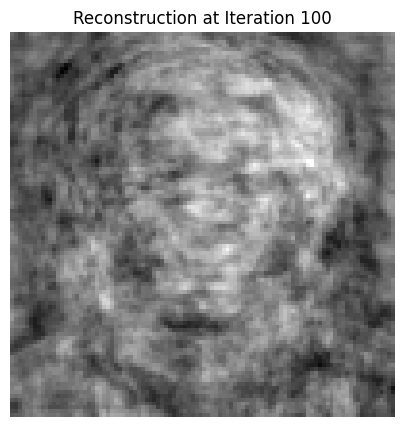

Iteration 200, Cost: 0.020642


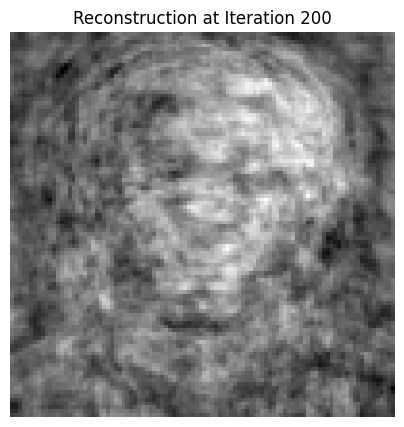

Iteration 300, Cost: 0.014495


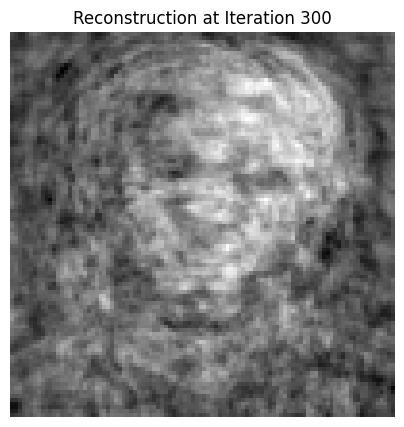

Iteration 400, Cost: 0.010756


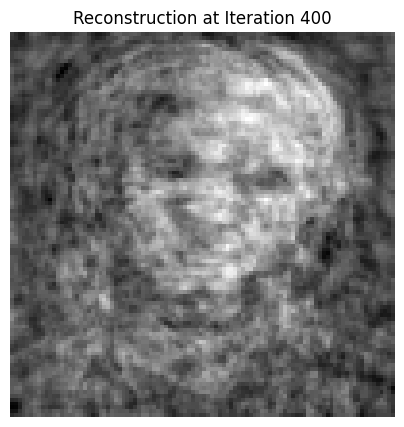

Iteration 500, Cost: 0.008296


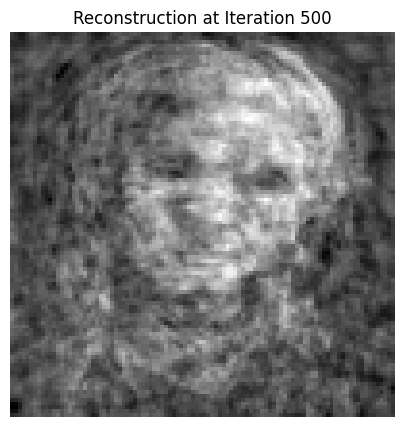

Iteration 600, Cost: 0.006576


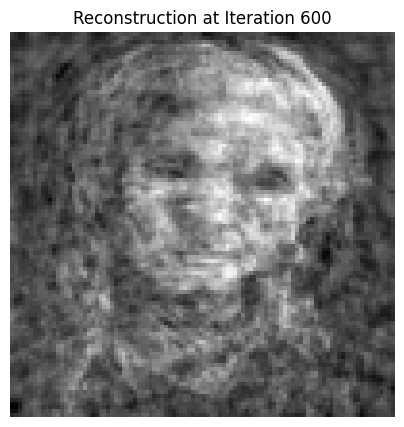

Iteration 700, Cost: 139.506631


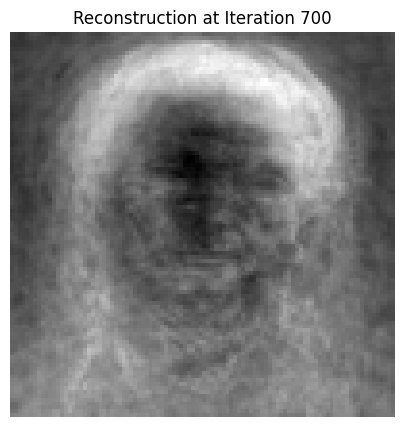

Iteration 800, Cost: 0.004666


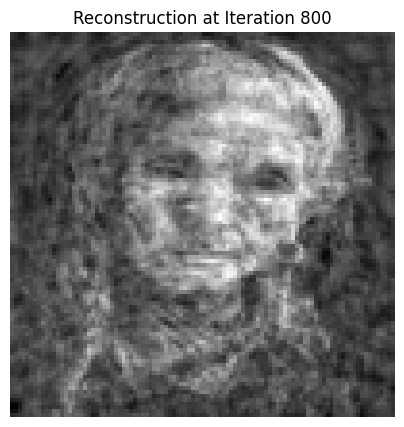

Iteration 900, Cost: 0.004092


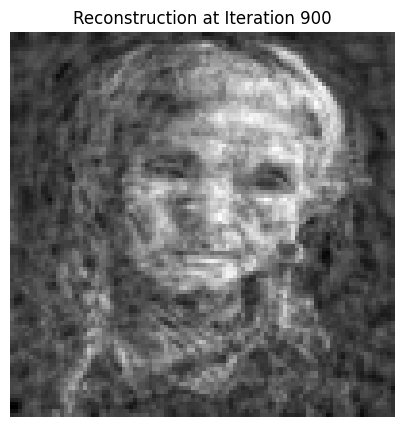

Iteration 1000, Cost: 0.003594


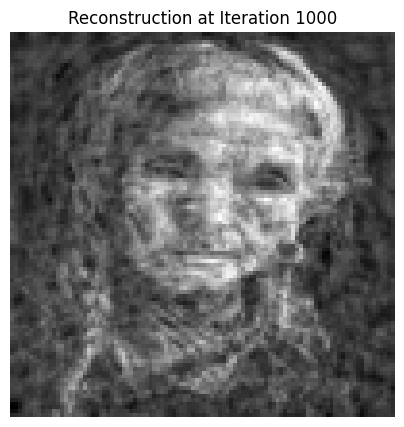

Iteration 1100, Cost: 0.003161


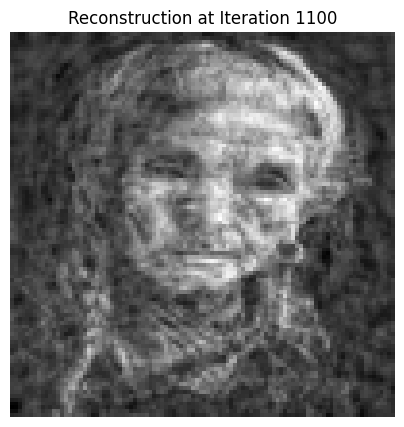

Iteration 1200, Cost: 143.344626


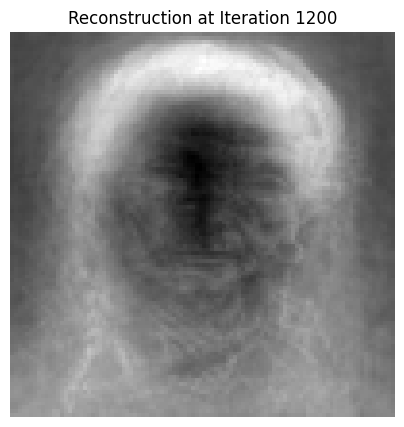

Iteration 1300, Cost: 0.002551


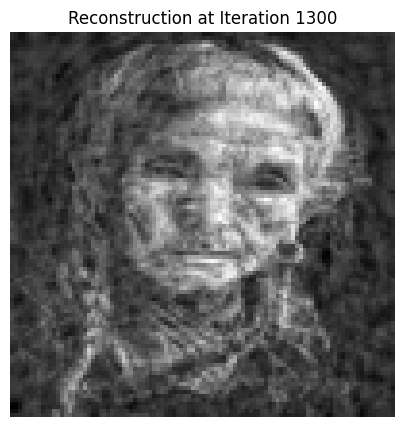

Iteration 1400, Cost: 0.002331


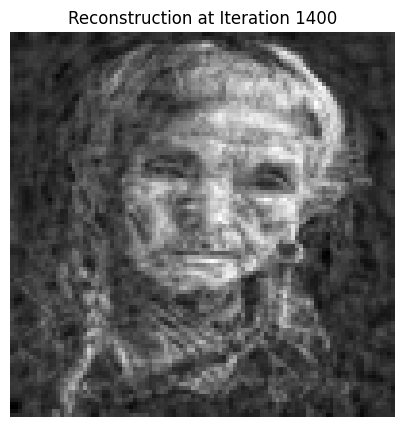

Iteration 1500, Cost: 0.002128


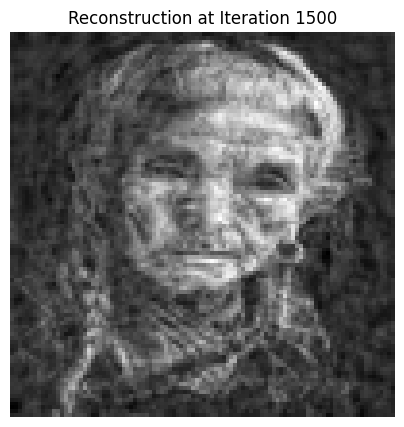

Iteration 1600, Cost: 0.001942


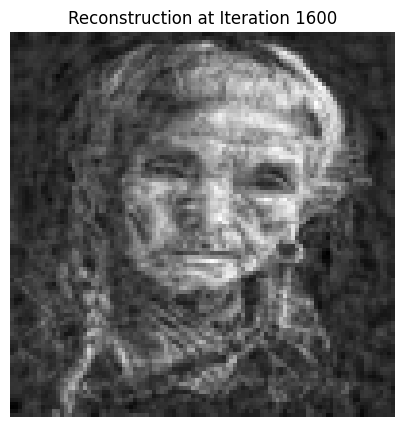

Iteration 1700, Cost: 0.002194


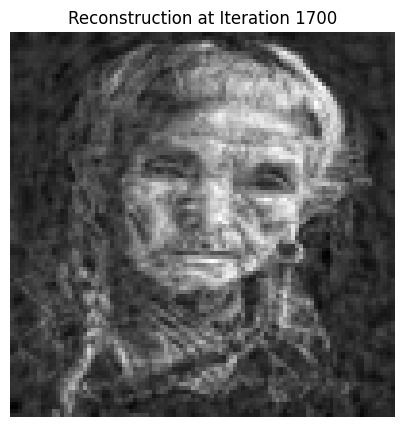

Iteration 1800, Cost: 0.001648


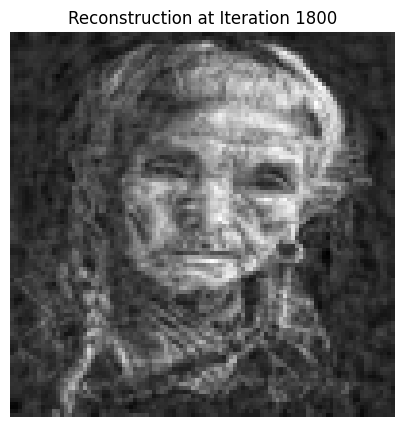

Iteration 1900, Cost: 0.001534


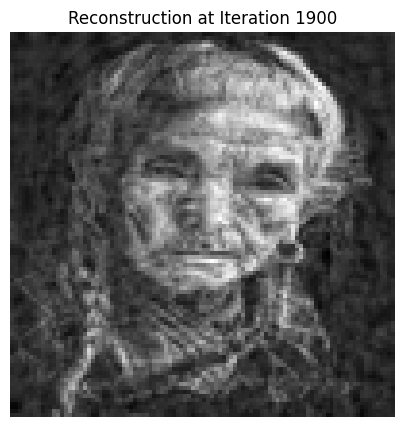

Iteration 2000, Cost: 0.001428


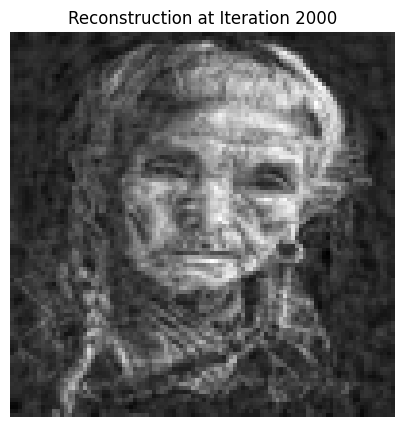

Iteration 2100, Cost: 0.001328


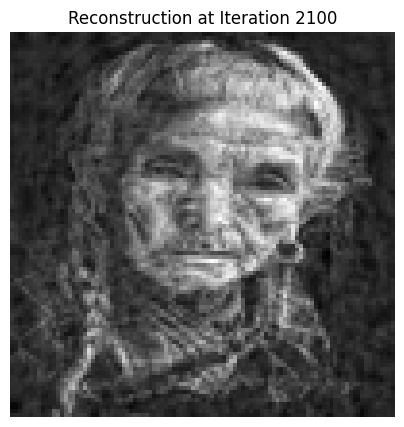

Iteration 2200, Cost: 0.001233


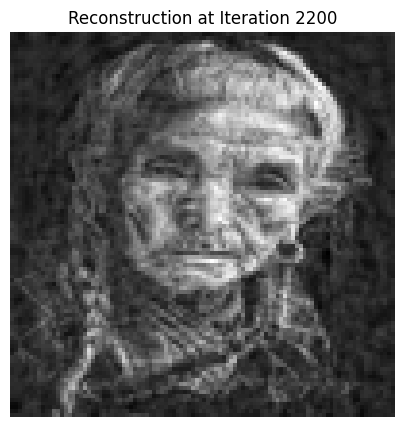

Iteration 2300, Cost: 0.001684


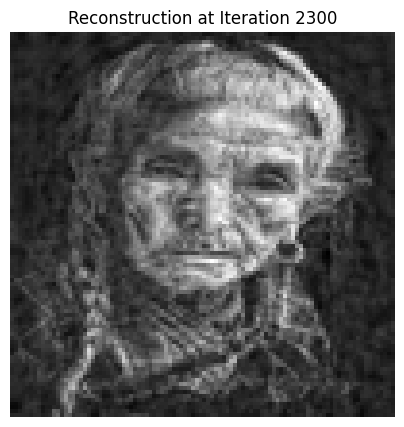

Iteration 2400, Cost: 0.001091


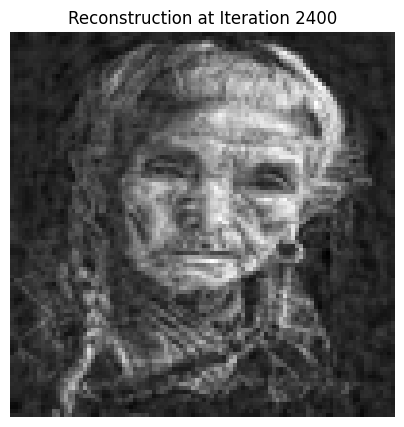

Iteration 2500, Cost: 0.001028


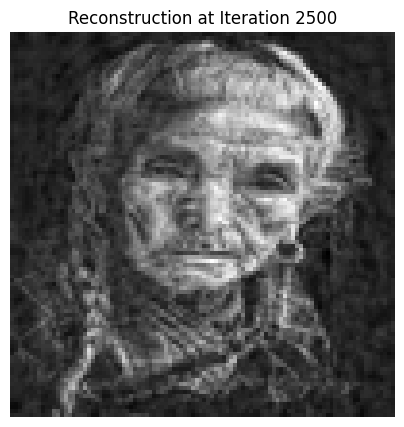

Iteration 2600, Cost: 0.000967


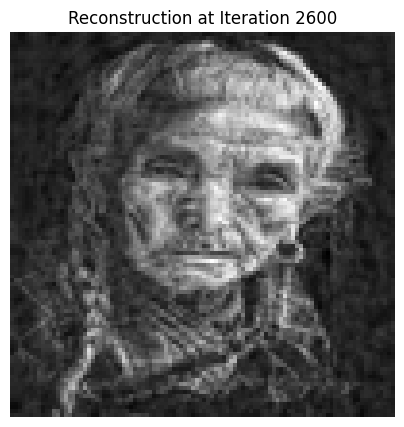

Iteration 2700, Cost: 0.000909


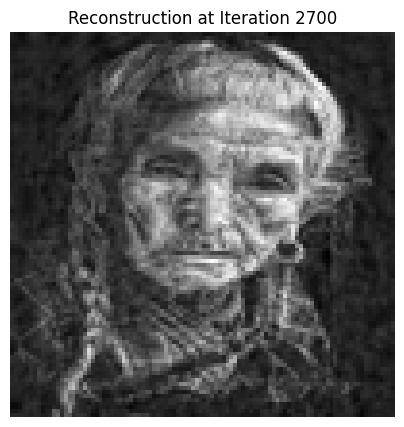

Iteration 2800, Cost: 0.819730


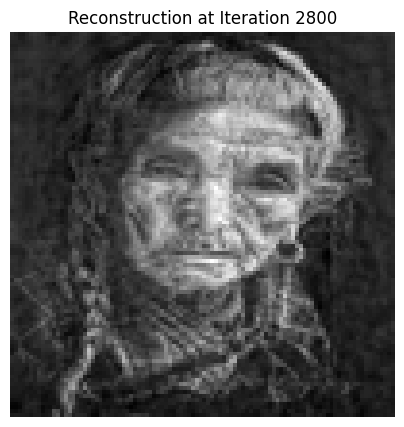

Iteration 2900, Cost: 0.000814


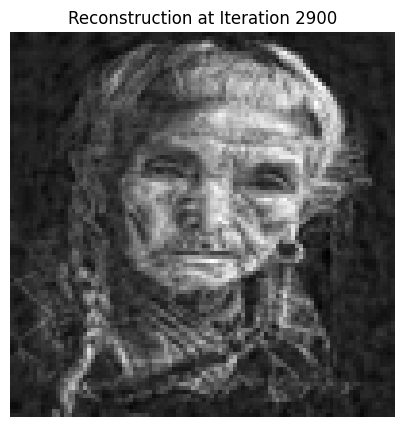

Iteration 3000, Cost: 0.000773


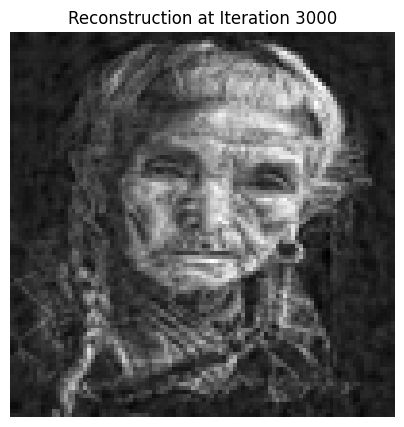

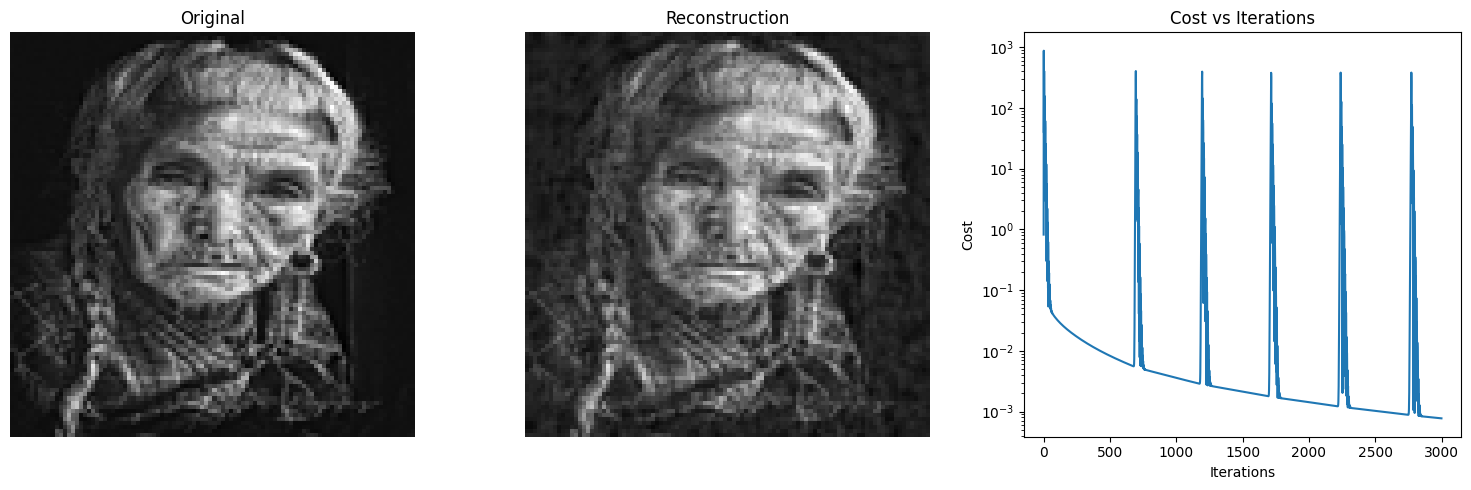

In [12]:
# Initialize the face reconstructor with specified image size and basis size
reconstructor = FaceReconstructor(image_size=100, num_basis=1000)

# Path to the dataset
dataset_path = "/root/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1/Humans"

# Reconstruct a random face from the dataset
original, reconstruction, costs = reconstructor.reconstruct_face(dataset_path)

# Plot the original and reconstructed faces along with the cost curve
def plot_results(original, reconstruction, costs):
    """Plot the results in a nice format"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')

    ax2.imshow(reconstruction, cmap='gray')
    ax2.set_title('Reconstruction')
    ax2.axis('off')

    ax3.plot(costs)
    ax3.set_title('Cost vs Iterations')
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Cost')
    ax3.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(original, reconstruction, costs)


#Calculate SSIM (Structural Similarity Index)

In [13]:
ssim_score, _ = ssim(original, reconstruction, full=True, data_range=1.0)
print(f"SSIM between the original and reconstructed image: {ssim_score:.4f}")

SSIM between the original and reconstructed image: 0.8942
